# Anime Recommender System

This notebook presents an anime recommender system that leverages both collaborative filtering and content-based filtering techniques. The recommender system aims to provide personalized anime recommendations based on user preferences and similarities between anime titles.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:
ratings_path = '/kaggle/input/anime-recommendation-database-2020/animelist.csv'
data_path = '/kaggle/input/anime-recommendation-database-2020/anime.csv'

In [3]:
anime_ratings = pd.read_csv(ratings_path)
anime_data = pd.read_csv(data_path)
anime_data.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [4]:
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17562 entries, 0 to 17561
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MAL_ID         17562 non-null  int64 
 1   Name           17562 non-null  object
 2   Score          17562 non-null  object
 3   Genres         17562 non-null  object
 4   English name   17562 non-null  object
 5   Japanese name  17562 non-null  object
 6   Type           17562 non-null  object
 7   Episodes       17562 non-null  object
 8   Aired          17562 non-null  object
 9   Premiered      17562 non-null  object
 10  Producers      17562 non-null  object
 11  Licensors      17562 non-null  object
 12  Studios        17562 non-null  object
 13  Source         17562 non-null  object
 14  Duration       17562 non-null  object
 15  Rating         17562 non-null  object
 16  Ranked         17562 non-null  object
 17  Popularity     17562 non-null  int64 
 18  Members        17562 non-n

In [5]:
anime_data = anime_data[['MAL_ID', 'Name', 'Score', 'Genres', 'Type', 'Episodes', 'Members']]
anime_data.rename(columns={'MAL_ID':"anime_id"}, inplace=True)
anime_data.info

<bound method DataFrame.info of        anime_id                             Name    Score  \
0             1                     Cowboy Bebop     8.78   
1             5  Cowboy Bebop: Tengoku no Tobira     8.39   
2             6                           Trigun     8.24   
3             7               Witch Hunter Robin     7.27   
4             8                   Bouken Ou Beet     6.98   
...         ...                              ...      ...   
17557     48481  Daomu Biji Zhi Qinling Shen Shu  Unknown   
17558     48483                     Mieruko-chan  Unknown   
17559     48488  Higurashi no Naku Koro ni Sotsu  Unknown   
17560     48491      Yama no Susume: Next Summit  Unknown   
17561     48492                    Scarlet Nexus  Unknown   

                                                  Genres   Type Episodes  \
0        Action, Adventure, Comedy, Drama, Sci-Fi, Space     TV       26   
1                  Action, Drama, Mystery, Sci-Fi, Space  Movie        1   
2      

In [6]:
anime_ratings = anime_ratings.sample(frac=0.2)
anime_ratings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21844949 entries, 80729188 to 75370393
Data columns (total 5 columns):
 #   Column            Dtype
---  ------            -----
 0   user_id           int64
 1   anime_id          int64
 2   rating            int64
 3   watching_status   int64
 4   watched_episodes  int64
dtypes: int64(5)
memory usage: 1000.0 MB


In [7]:
anime_ratings.anime_id.nunique()

17552

In [8]:
anime_complete = pd.merge(anime_data, anime_ratings, on='anime_id')
anime_complete = anime_complete.rename(columns={'rating': 'user_rating', 'Score': 'total_rating', "Name":'anime_title'})
anime_complete.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21844949 entries, 0 to 21844948
Data columns (total 11 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   anime_id          int64 
 1   anime_title       object
 2   total_rating      object
 3   Genres            object
 4   Type              object
 5   Episodes          object
 6   Members           int64 
 7   user_id           int64 
 8   user_rating       int64 
 9   watching_status   int64 
 10  watched_episodes  int64 
dtypes: int64(6), object(5)
memory usage: 2.0+ GB


In [9]:
anime_complete.isna().sum()

anime_id            0
anime_title         0
total_rating        0
Genres              0
Type                0
Episodes            0
Members             0
user_id             0
user_rating         0
watching_status     0
watched_episodes    0
dtype: int64

# Exploratory Data Analysis

This visualization allows us to easily identify the top 10 anime titles based on the frequency of user ratings. The height of each bar represents the user rating count for the corresponding anime title.

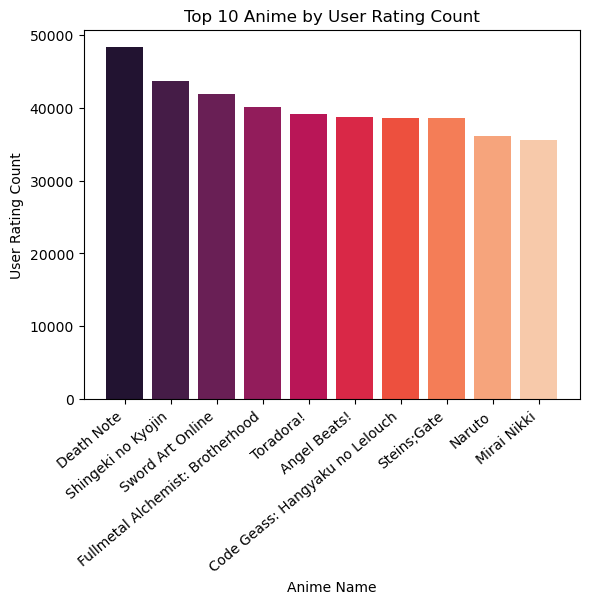

In [10]:
top_10_anime = anime_complete['anime_title'].value_counts().nlargest(10)
palette = sns.color_palette('rocket', len(top_10_anime))

plt.bar(top_10_anime.index, top_10_anime.values, color=palette)

plt.title("Top 10 Anime by User Rating Count")
plt.xlabel("Anime Name")
plt.ylabel("User Rating Count")

plt.xticks(rotation=40, ha="right")

plt.show()

This visualization allows us to easily identify the top 10 anime titles with the highest number of members. The height of each bar represents the corresponding number of members for each anime title

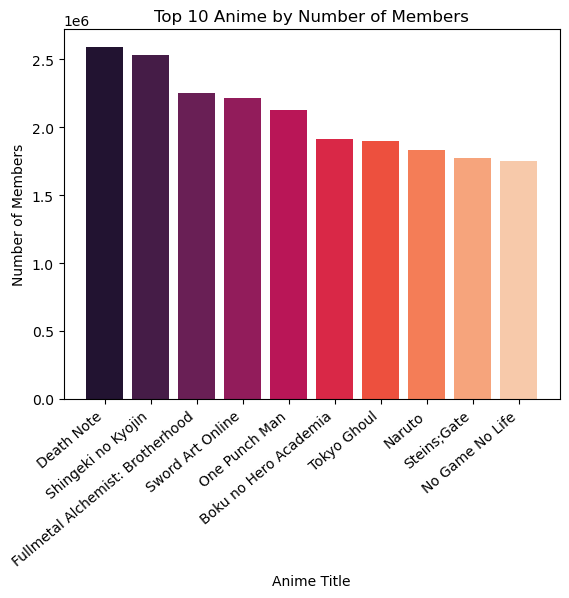

In [11]:
top_10_anime = anime_complete.sort_values(by="Members", ascending=False).drop_duplicates(subset='anime_title').head(10)

palette = sns.color_palette('rocket', len(top_10_anime))

plt.bar(top_10_anime['anime_title'], top_10_anime['Members'], color=palette)

plt.title("Top 10 Anime by Number of Members")
plt.xlabel("Anime Title")
plt.ylabel("Number of Members")

plt.xticks(rotation=40, ha='right')

plt.show()

In [12]:
anime_features = anime_complete.copy()
anime_features.head()

,anime_id,anime_title,total_rating,Genres,Type,Episodes,Members,user_id,user_rating,watching_status,watched_episodes
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,1251960,96430,8,2,26
1,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,1251960,81097,10,2,26
2,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,1251960,56887,10,2,26
3,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,1251960,64965,0,6,0
4,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",TV,26,1251960,303015,8,2,26


In [13]:
user_id_counts = anime_features['user_id'].value_counts()
user_id_counts.describe()

count    318700.000000
mean         68.543925
std          85.762382
min           1.000000
25%          20.000000
50%          46.000000
75%          89.000000
max        3592.000000
Name: user_id, dtype: float64

*In order to consider only the reviewers of "trusted" members, the ones we are considering trustworthy are those who have reviewed a certain number (100 in our case) of animes, the rest of the reviewers may be dropped.*

In [14]:
anime_features = anime_features[anime_features['user_id'].isin(user_id_counts[user_id_counts >= 100].index)]

Since the title text was not found to be clean we a function to clean the title names using regex:

In [15]:
def text_cleaning(text):
    text = re.sub(r'&quot;', '', text)
    text = re.sub(r'.hack//', '', text)
    text = re.sub(r'&#039;', '', text)
    text = re.sub(r'A&#039;s', '', text)
    text = re.sub(r'I&#039;', 'I\'', text)
    text = re.sub(r'&amp;', 'and', text)
    return text

In [16]:
anime_features['anime_title'] = anime_features['anime_title'].apply(text_cleaning)
anime_pivot = anime_features.pivot_table(index='anime_title', columns='user_id', values='user_rating').fillna(0)

# Collaborative Filtering
Collaborative filtering is a technique used in recommender systems to predict user preferences or make recommendations by identifying similarities and patterns among users' preferences. It assumes that users with similar preferences in the past are likely to have similar preferences in the future. Collaborative filtering can be performed using user-based or item-based approaches, where user-based focuses on finding similar users to make recommendations, while item-based focuses on finding similar items. By leveraging these similarities, collaborative filtering helps users discover new items or content based on the preferences and behaviors of similar users, improving the overall user experience and engagement.

## Cosine Similarity using KNN

Cosine similarity is a measure of similarity between two non-zero vectors of an inner product space. In the context of recommendation systems, cosine similarity is often used to determine how similar two items or users are based on their feature vectors.


In [17]:
anime_data["Name"] = anime_data["Name"].apply(text_cleaning)

Sparse matrix was created to optimize the memory usage and computational efficiency of the model. The user-anime matrix can be very large and the majority of the entries are likely to be zeros, which means that they don't contribute to the similarity computations. By converting the matrix to a sparse format, we can represent it using less memory, and perform computations only on the non-zero entries. This can significantly speed up the model training and recommendation generation processes.

In [18]:
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

anime_matrix = csr_matrix(anime_pivot.values)

model_knn = NearestNeighbors(metric='cosine', algorithm='brute')

model_knn.fit(anime_matrix)

NearestNeighbors(algorithm='brute', metric='cosine')

In [19]:
anime_title = np.random.choice(anime_pivot.index)

print(f"Randomly selected anime title: {anime_title} \n")

query_index = anime_pivot.index.get_loc(anime_title)

distances, indices = model_knn.kneighbors(anime_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors=6)

print(f"Recommendations for {anime_pivot.index[query_index]}:\n")

for i, (distance, index) in enumerate(zip(distances.flatten()[1:], indices.flatten()[1:])):
    print(f"{i+1}: {anime_pivot.index[index]}, with distance of {distance}")
    

Randomly selected anime title: Zero Seiki Movie 1: Emeraldas 

Recommendations for Zero Seiki Movie 1: Emeraldas:

1: Pan de Peace!, with distance of 1.0
2: Palladium: siroPd Motion Collective, with distance of 1.0
3: Pakomane: Watashi, Kyou kara Meimon Yakyuubu no Seishorigakari ni Narimasu... The Animation, with distance of 1.0
4: Pan to Boku no Momo-chan, with distance of 1.0
5: Paizuri Cheerleader vs. Sakunyuu Ouendan!, with distance of 1.0


In [20]:
def give_rec_knn(anime_title = np.random.choice(anime_pivot.index), anime_pivot=anime_pivot):
    
    print(f"Selected anime title: {anime_title} \n")

    query_index = anime_pivot.index.get_loc(anime_title)

    distances, indices = model_knn.kneighbors(anime_pivot.iloc[query_index, :].values.reshape(1, -1), n_neighbors=6)

    print(f"Recommendations for {anime_pivot.index[query_index]}:\n")

    for i, (distance, index) in enumerate(zip(distances.flatten()[1:], indices.flatten()[1:])):
        print(f"{i+1}: {anime_pivot.index[index]}, with distance of {distance}")

In [21]:
give_rec_knn("Steins;Gate")
give_rec_knn()

Selected anime title: Steins;Gate 

Recommendations for Steins;Gate:

1: Code Geass: Hangyaku no Lelouch, with distance of 0.8358692164877071
2: Fullmetal Alchemist: Brotherhood, with distance of 0.839615046888026
3: Shingeki no Kyojin, with distance of 0.8398457763538509
4: Angel Beats!, with distance of 0.8402467282822863
5: Death Note, with distance of 0.840734778589951
Selected anime title: Memories: Younenki no Joukei 

Recommendations for Memories: Younenki no Joukei:

1: Greek Roman Sinhwa: Olympus Guardian (Movie), with distance of 0.41492603378536586
2: Kazaguruma, with distance of 0.41621282275255667
3: Yasashii Kaze, with distance of 0.4279889741873689
4: Oniichan ni Natchatta, with distance of 0.4301342801415037
5: No Shiba no Shiba, with distance of 0.4330591071437755


## Content Based Filtering
Content-based filtering is a recommendation system technique that recommends items based on their intrinsic features or attributes. It identifies items similar to the ones the user has shown interest in and recommends them. For example, a movie recommendation system might recommend other movies with similar genres, actors, directors, or plot themes to those previously watched by the user. Content-based filtering does not rely on the preferences of other users and can work well for new or niche items with little user data. However, it may suffer from limited diversity in recommendations and inability to capture serendipitous recommendations.

## TF-IDF Vectorizer
TF-IDF stands for Term Frequency-Inverse Document Frequency.<br>
TF-IDF vectorizer is a specific implementation of the TF-IDF technique. It is a commonly used technique in natural language processing to convert a collection of text documents into numerical feature vectors, which can be used for machine learning tasks like text classification or clustering.
* It first counts the number of occurrences of each word (term) in each document (text) in the collection, and then * calculates a weight for each term based on how frequently it appears across all documents. 
* The weight is higher for terms that appear frequently in a particular document, but not so much in other documents. 
* The weight is also higher for terms that appear less frequently across all documents.

This helps to give more importance to words that are relevant to a specific document and less importance to common words that are not specific to any document.

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfv = TfidfVectorizer(min_df=3, max_features=None, strip_accents='unicode', analyzer='word', token_pattern=r'\w{1,}', ngram_range=(1, 3), stop_words='english')

anime_data['Genres'] = anime_data['Genres'].fillna('')

genres_str = anime_data['Genres'].str.split(',').astype(str)

tfv_matrix = tfv.fit_transform(genres_str)

print(tfv_matrix.shape)

(17562, 2283)


The sigmoid kernel is a type of kernel function used in machine learning for non-linear classification and regression. It maps the data into a higher-dimensional space and computes the dot product between two data points in that space. 
* The sigmoid_kernel is a similarity function that computes the sigmoid kernel between two input feature vectors.

* It is commonly used in machine learning for non-linear classification and regression tasks.

* The sigmoid kernel function takes two feature vectors as input and computes a value between 0 and 1, where 1 indicates a high degree of similarity between the two vectors and 0 indicates no similarity.

* The sigmoid kernel function applies the sigmoid function to the dot product of the two feature vectors, which transforms the dot product into a value between 0 and 1.

* The `sigmoid_kernel` is being used to compute the similarity between anime genres based on their TF-IDF feature vectors, which can be used for content-based recommendation systems.

In [23]:
from sklearn.metrics.pairwise import sigmoid_kernel

sig = sigmoid_kernel(tfv_matrix, tfv_matrix)

In [24]:
indices = pd.Series(anime_data.index, index=anime_data['Name'])

indices = indices.drop_duplicates()

In [25]:
def give_rec_cbf(title, sig=sig):
    idx = indices[title]
    
    sig_scores = list(enumerate(sig[idx]))
    
    sig_scores = sorted(sig_scores, key=lambda x: x[1], reverse=True)
    
    anime_indices = [i[0] for i in sig_scores[1: 11]]
    
    top_anime = pd.DataFrame({
        'Anime name': anime_data['Name'].iloc[anime_indices].values,
        'Rating': anime_data['Score'].iloc[anime_indices].values
    })
    return top_anime

In [26]:
give_rec_cbf('One Piece')

,Anime name,Rating
0,One Piece: Episode of Sabo - 3 Kyoudai no Kizu...,7.72
1,One Piece: Long Ring Long Land-hen,6.74
2,One Piece: Episode of East Blue - Luffy to 4-n...,7.91
3,One Piece: Episode of Sorajima,7.11
4,Shingeki no Kyojin OVA,7.83
5,Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa,7.74
6,R.O.D: The TV,7.55
7,Zetsubou Funsai Shoujo ∞ Amida,6.55
8,One Piece Movie 1,7.1
9,One Piece Movie 2: Nejimaki-jima no Daibouken,7.17
